# ISYE/Math/CS 425 - Final - Helper
- Bryan Luu

All code in Julia 1.5.2

## Contents
- [Helper Functions](#Helper-Functions)
- [Max-Flow](#Max-Flow)
- [Optimal Matchings](#Optimal-Matchings)
- [TSP](#TSP)

Import libraries

In [2]:
using LightGraphs, MetaGraphs, LightGraphsMatching, GraphRecipes, Plots

## Helper Functions

In [159]:
# connects adjacent vertices in list of vertices P
connect(P::Vector{Int}, Etype=Edge) = [Etype(u, v) for (u, v) in zip(P[1:end-1], P[2:end])];
# checks if vertex v is incident to edge e
incident(v::Int, e::T) where {T <: AbstractEdge} = e.src == v || e.dst == v; 
# prints a sum: x[1] + x[2] + ... = sum(x)
sum_str(x::Vector{N}) where {N <: Number} = join(x, " + ") * " = $(sum(x))";
 # get the weight list of the edgelist from the weight dictionary
wts(E::Vector{T}, 
    wd::Dict{Tuple{Int, Int}, N}) where {T <: AbstractEdge, N <: Number} = [wd[(e.src, e.dst)] for e in E];
 # function to convert array into array of symbols
to_sym(v::Array) = map(x->Symbol(x), v);
# Return a centered array of num_elements numbers separated by spacing
centered(num_elements::Int, 
    spacing::Real) = [i*spacing for i in 0:num_elements-1] .- (num_elements-1)*spacing/2;

# E list of Edges in a path, topologically sorted (i.e. E[1] -> E[2] -> ... -> E[end])
function disconnect(E::Vector{T}) where {T <: AbstractEdge}
    path = []
    s = nothing;
    for e in E
        s, d = e.src, e.dst;
        push!(path, s);
        s = d;
    end
    push!(path, s);
    return path
end

# Similar to Base.unique except includes options for undirected edges
function unique(E::Vector{T}; directed=false) where {T <: AbstractEdge}
    tmp = copy(E);
    new = T[];
    while !isempty(tmp)
        e = pop!(tmp);
        removed = remove!(e, tmp; directed=directed);
        push!(new, e);
    end
    return new;
end

# Returns a normalized x where (min(x), max(x)) -> (0, 1)
function normalize(x::N) where {N <: Union{Real, Array{<:Real}}}
    mx, Mx = min(x...), max(x...); # limits
    return Mx == mx ? x.*0 : (x.-mx)./(Mx .- mx)
end

# Set the position metadata of vertex v
function place!(mg::G, v::Int, 
        position::Tuple{T, N}) where {G <: Union{MetaGraph, MetaDiGraph}, T <: Real, N <: Real}
    set_prop!(mg, v, :position, position);
end

# Add edge between vertex u, v in MetaGraph mg, with weight metadata,
# updating the weight dictionary if given.
function connect!(mg::G, u::Int, v::Int, weight::N; 
        wd::D=nothing) where {G <: Union{MetaGraph, MetaDiGraph}, N <: Real, D <: Union{Nothing, Dict}}
    add_edge!(mg, u, v);
    set_prop!(mg, u, v, :weight, weight);
    if wd != nothing
        wd[(u, v)] = wd[(v, u)] = weight;
    end
end

# Remove edge e from a copy of edge list E, with a default flag for undirected edges
function remove(e::T, E::Vector{T}; directed::Bool=false, 
        condition=(k)->(k == e || (!directed && k == reverse(e)))) where {T <: AbstractEdge}
    return [k for k in E if !condition(k)];
end

# Remove edge e from edge list E in place, with a default flag for undirected edges
# Returns any edges removed
function remove!(e::T, E::Vector{T}; directed::Bool=false, 
        condition=(k)->(k == e || (!directed && k == reverse(e)))) where {T <: AbstractEdge}
    i = 1;
    removed = T[]
    while i <= length(E)
        if condition(E[i])
            push!(removed, popat!(E, i));
            continue;
        end
        i += 1;
    end
    return removed;
end

# Returns an edge-weight function that emphasizes the edges in edgelist E,
function emphasize(E::Union{Set{T}, Vector{T}}; in_weight=3, out_weight=1,
        directed=false) where {T <: AbstractEdge}
    function ew(s, d, w)
        e = T(s, d);
        re = reverse(e);
        if in(e, E) || (!directed && in(re, E))
            return in_weight;
        else
            return out_weight;
        end
    end
    return ew;
end;

# IJulia only... inline display
function show_plot(plt; show=true, title="")
    show || return; # return if show=false
    title!(plt, title);
    display(Main.IJulia.InlineDisplay(), plt);
end

# Helper function to plot the given metagraph with fixed positions
function plot_fixed(g::G; names=vertices(g), positions=[], 
        ew=(s, d, w)->1, args...) where {G <: Union{MetaGraph, MetaDiGraph}}
    N = nv(g);

    mg = copy(g); # create internal connected copy
    fake = Dict();
    if !is_connected(mg)
        for v in 2:N
            if is_connected(mg)
                break
            end
            if !has_edge(g, 1, v)
                add_edge!(mg, 1, v);
                fake[1, v] = true;
            end
        end
    end

    new_ew(s, d, w) = get(fake, (s, d), false) ? 0 : ew(s, d, w);

    if isempty(positions)
        positions = [get_prop(g, v, :position) for v in 1:N];
    end
    
    x = [pos[1] for pos in positions];
    y = [pos[2] for pos in positions];
    
    p = hcat(x, y); # Position
    sp = normalize(p); # Scale so that the positions are normalized
    
    graphplot(mg; x=sp[:, 1], y=sp[:, 2], names=names, ew=new_ew, args...);
end;

In [7]:
# Bread-first-search for (u,v)-path in the graph defined by graph g
function BFS(g::G, u::Int, v::Int) where {G <: AbstractGraph}
    p = Dict{Int, Int}(zip(vertices(g), -1*ones(nv(g))));
    p[u] = 0;
    q = Int[u]; # queue for BFS
    while !isempty(q)
        curr = popfirst!(q);
        if curr == v
            break
        end
        for n in neighbors(g, curr)
            if p[n] == -1
                push!(q, n);
                p[n] = curr;
            end
        end
    end
    i = v;
    path = Int[];
    while(i != u)
        if p[i] == -1
            return Int[]
        else
            pushfirst!(path, i);
            i = p[i];
        end
    end
    pushfirst!(path, u);
    return path
end;

In [5]:
function cut(g::AbstractGraph, U::Union{Set{Int}, Vector{Int}}; directed::Bool=is_directed(g))
    delta = Edge[];
    inside = Int[];
    outside = Int[];
    for e in edges(g)
        if in(e.src, U) && !in(e.dst, U)
            push!(delta, e);
            push!(inside, e.src);
            push!(outside, e.dst);
        elseif !directed && !in(e.src, U) && in(e.dst, U)
            push!(delta, e);
            push!(inside, e.dst);
            push!(outside, e.src);
        end
    end
    return delta, inside, outside;
end;

## Max Flow
- [Max-Flow Functions](#Max-Flow-Functions)
- [Max-Flow Input](#Max-Flow-Input)
- [Bi-partite Max Matchings Input](#Bi-partite-Max-Matchings-Input)

### Max-Flow Functions

In [128]:
# calculate the flow into vertex v given flows x
function flow(x::Dict{T, N}, v::Int) where {T <: Union{AbstractEdge, Tuple{Int, Int}}, N <: Real}
    E = keys(x);
    inflow = sum(N[x[e] for e in E if e.dst==v]);
    outflow = sum(N[x[e] for e in E if e.src==v]);
    inflow - outflow
end;

In [129]:
# Construct auxiliary graph of metagraph from flow x
function auxiliary_graph(mg::MetaDiGraph, x::Dict{T, N}) where {T <: AbstractEdge, N <: Real}
    aux = copy(mg);
    # Construct capacities
    u = Dict(e => get_prop(mg, e, :weight) for e in edges(mg));
    for e in edges(mg)
        rem_edge!(aux, e); # Delete the existing edge first
        if x[e] < u[e]
            add_edge!(aux, e); # add forward arc
            set_prop!(aux, e, :forward, true); # set edge to a forward arc
        end
        if x[e] > 0
            rev = reverse(e);
            add_edge!(aux, rev); # add a reverse arc
            set_prop!(aux, rev, :reverse, true); # set edge as reverse arc
        end
    end
    return aux;
end;

In [130]:
# Augmenting path algorithm for metagraph mg with capacities defined by edge weights, and source and sink.
function APA(mg::MetaDiGraph, source, sink; names=Vector(1:nv(mg)), 
        verbose::Bool=false, show_graphs::Bool=false) where {T <: Union{String, Symbol, Int}}
    log(msg::Any) = verbose ? println(msg) : nothing # printer
    isreverse(aux::MetaDiGraph, e::T) where {T <: AbstractEdge} = has_prop(aux, e, :reverse);
    isforward(aux::MetaDiGraph, e::T) where {T <: AbstractEdge} = has_prop(aux, e, :forward);
    ename(e::T) where {T <: AbstractEdge} = "$(names[e.src]), $(names[e.dst])";
    index = Dict(name => i for (i, name) in enumerate(names));
    r, s = index[source], index[sink];
    
    # Construct capacities
    u = Dict(e => get_prop(mg, e, :weight) for e in edges(mg));
    u_max = max(values(u)...) # max capacity
    
    # Construct flow vector
    x = Dict{edgetype(mg), valtype(u)}(zip(edges(mg), zeros(ne(mg))));
    
    # Returns a scaled flow where x=0 -> low and x=max_flow -> high
    function flow_ew(low::T, high::N; max_flow=u_max) where {T <: Real, N <: Real}
        if max_flow == Inf
            return (s, d, w) -> high;
        end
        return (s, d, w) -> low + (max_flow == 0 ? 0 : (high-low)*x[Edge(s, d)]/max_flow);
    end
    plot_flow(g::MetaDiGraph; ew=flow_ew(0.5, 3), 
        args...) = plot_fixed(g; ew=ew, names=names, curvature=0.005, args...);
    
    log("---Setup---")
    log("Edge\tu, x")
    for e in edges(mg)
        log(ename(e) * ":\t$(u[e]), $(x[e])")
    end
    show_plot(plot_flow(mg; ew=(s, d, w)->1, el=Dict((e.src, e.dst)=>"$(u[e])" for e in edges(mg)), 
            elb=false, elo=0.01); show=show_graphs, title="Input graph");
    
    # Construct auxiliary digraph
    aux = auxiliary_graph(mg, x);
    
    path = BFS(aux, r, s);
    arcs = connect(path);
    i = 1;
    while(!isempty(path))
        log("---Iteration $(i)---")
        show_plot(plot_flow(aux; ew=emphasize(arcs; directed=true));
            show=show_graphs, title="Auxiliary graph at iteration $(i)");
        log("x-augmenting path: " * join(map((v)->string(names[v]), path), ", "))

        # find x-width
        eps1 = min(Inf, [u[e] - x[e] for e in arcs if isforward(aux, e)]...);
        eps2 = min(Inf, [x[reverse(e)] for e in arcs if isreverse(aux, e)]...);
        log("ε1: $(eps1)")
        log("ε2: $(eps1)")
        x_width = min(eps1, eps2);
        
        log("x-width: $(x_width)")

        if x_width == Inf
            break
        end

        for e in arcs
            if isforward(aux, e)
                x[e] += x_width; # increase flow on forward arcs
            end
            if isreverse(aux, e)
                x[reverse(e)] -= x_width; # decrease flow on reverse arcs
            end
        end

        log("Edge\tu, x")
        for e in edges(mg)
            log(ename(e) * ":\t$(u[e]), $(x[e])")
        end
        
        max_flow = (u_max == Inf ? min([u[e] for e in arcs]...) : u_max);
        show_plot(plot_flow(mg; ew=flow_ew(0.5, 3; max_flow=max_flow), 
                el=Dict((e.src, e.dst)=>"$(u[e]), $(x[e])" for e in edges(mg)), 
                elo=0.025, elb=false); show=show_graphs, title="Flow at iteration $(i)");

        # Create auxiliary graph from flows
        aux = auxiliary_graph(mg, x);
        log("Auxiliary graph: ")
        for e in edges(aux)
            log("$(names[e.src]) => $(names[e.dst])")
        end
        
        path = BFS(aux, r, s);
        if !isempty(path)
            arcs = connect(path);
        end
        i += 1;
    end

    show_plot(plot_flow(aux; ew=emphasize(arcs; directed=true)); show=show_graphs, title="Final auxiliary graph");
    log("No augmenting path left...")
    
    max_flow = flow(x, s);
                           
    log("===== OPTIMUM FOUND =====")
    log("Max-flow: $(max_flow)")
    show_plot(plot_flow(mg, el=Dict((e.src, e.dst)=>"$(u[e]), $(x[e])" for e in edges(mg)), 
                elo=0.025, elb=false); show=show_graphs, title="Optimal Flow");
                                    
    return (max_flow, x);
end;

In [131]:
# Get maximum matching for bipartite graph defined by node sets P, Q, and adjacency list L
function max_matching_bipartite(P::Union{Set, Array}, Q::Union{Set, Array}, L::Dict;
        verbose::Bool=false, show_graphs::Bool=false, args...)
    log(msg::Any) = verbose ? println(msg) : nothing # printer
    P, Q = collect(Base.unique(P)), collect(Base.unique(Q)); # Convert into arrays
    
    (isempty(P) || isempty(Q)) && return []; # return if P or Q is empty
    
    names = [:source, :sink, P..., Q...];
    index = Dict(name => i for (i, name) in enumerate(names));
    V = collect(1:length(names));
    r, s = index[:source], index[:sink]; # Indices of source and sink nodes
    wd = Dict(); # Weight dictionary

    # Build input graph for APA
    mg = MetaDiGraph(length(names));
    for p in P
        connect!(mg, r, index[p], 1; wd=wd); # Connect source to P nodes with weight 1
    end
    for q in Q
        connect!(mg, index[q], s, 1; wd=wd); # Connect Q to sink nodes with weight 1
    end
    for u in keys(L) # Connect P to Q nodes with weight Inf using adjacency list
        if in(u, P)
            for v in L[u]
                in(v, Q) && connect!(mg, index[u], index[v], Inf; wd=wd);
            end
        elseif in(u, Q)
            for v in L[u]
                in(v, P) && connect!(mg, index[v], index[u], Inf; wd=wd);
            end
        end
    end
    
    max_len = max(length(P), length(Q));
    vertical_spacing = 1;
    horizontal_spacing = vertical_spacing*(max_len - 1)/2;
    x_P = zeros(length(P));
    x_Q = horizontal_spacing*ones(length(Q));
    y_P = centered(length(P), vertical_spacing);
    y_Q = centered(length(Q), vertical_spacing);
    x_r = -horizontal_spacing;
    x_s = 2*horizontal_spacing;
    y_r = y_s = 0;
    
    place!(mg, r, (x_r, y_r));
    place!(mg, s, (x_s, y_s));
    for (i, p) in enumerate(P)
        place!(mg, index[p], (x_P[i], y_P[i]));
    end
    for (i, q) in enumerate(Q)
        place!(mg, index[q], (x_Q[i], y_Q[i]));
    end
    
    V_PQ = filter((v)->(v != r && v != s), V); # node indices of P, Q
    ig, Imap = induced_subgraph(MetaGraph(mg), V_PQ); # graph induced by P, Q
    inv_Imap = Dict(v => i for (i, v) in enumerate(Imap)); # inverse Imap
    
    show_plot(plot_fixed(ig; names=[names[Imap[i]] for i in vertices(ig)], curvature=0, args...);
        show=show_graphs, title="Input graph");
    
    log("Using APA to solve for max-matchings...");
    
    max_matchings, x = APA(mg, r, s);
    
    E = [e for e in edges(mg)];
    M = [Edge(inv_Imap[e.src], inv_Imap[e.dst]) for e in edges(mg) if (e.src != r && e.dst != s) && x[e] > 0];
    Msize = length(M);
    
    show_plot(plot_fixed(mg; names=[((v == r || v == s) ? " " : names[v]) for v in V],
        ew=emphasize(filter((e)->(x[e] > 0), E), in_weight=2, out_weight=0.5), 
        curvature=0, args...); show=show_graphs, title="APA output flow");
    
    log("Maximum Matching M:");
    for e in M
        s, d = Imap[e.src], Imap[e.dst];
        log("$(names[s]) <=> $(names[d])");
    end
    log("|M| = $(Msize)");
    
    show_plot(plot_fixed(ig; names=[names[Imap[i]] for i in vertices(ig)], curvature=0,
        ew=emphasize(M; out_weight=0.5), args...);
        show=show_graphs, title="Maximum Matching M");
    
    matches = [(names[Imap[e.src]], names[Imap[e.dst]]) for e in M];
    return Msize, matches
end;

### Max-Flow Input

In [ ]:
V_str = "rpbacsqd"; # String representing all nodes
v_names = to_sym(collect(V_str)); # Node names
V = Vector(1:length(V_str)); # Node indices
index = Dict(v_names[i] => i for i in V); # Map from names to indices

L = Dict{Symbol, Any}(zip(v_names, [[] for v in V])); # Adjacency list
L[:r] = [:p, :a, :q];
L[:p] = [:q, :b];
L[:b] = [:a, :s];
L[:a] = [:c, :d];
L[:c] = [:q, :s, :b];
L[:q] = [:p, :b, :d];
L[:d] = [:c, :s];

Lu = Dict{Symbol, Any}(zip(v_names, [[] for v in V])); # Capacities in Adjacency List form
Lu[:r] = [6, 9, 4];
Lu[:p] = [2, 3];
Lu[:b] = [1, 8];
Lu[:a] = [8, 1];
Lu[:c] = [1, 4, 2];
Lu[:q] = [1, 2, 6];
Lu[:d] = [1, 6];

# Create metagraph
mg = MetaDiGraph(length(V_str));
for i in v_names
    for (k, j) in enumerate(L[i])
        s, d = index[i], index[j];
        add_edge!(mg, s, d);
        set_prop!(mg, s, d, :weight, Lu[i][k]);
    end
end

# Position vertices
place!(mg, index[:r], (0, 0));
place!(mg, index[:p], (1, 2));
place!(mg, index[:q], (2, -2));
place!(mg, index[:a], (2.3, 0.5));
place!(mg, index[:c], (3.5, 0));
place!(mg, index[:b], (3.6, 2));
place!(mg, index[:d], (4.4, -2));
place!(mg, index[:s], (5.5, 0));

In [ ]:
max_flow, x = APA(mg, :r, :s, names=v_names, verbose=true, show_graphs=true);
println("Max-flow: $(max_flow)");

### Bi-partite Max Matchings Input

In [ ]:
P_str = "abcdefghij"; # Specify P here as a string
Q_str = uppercase(P_str); # Specify Q here as a string

P, Q = to_sym(collect(P_str)), to_sym(collect(Q_str)); # creates arrays for P and Q

L = Dict();
L[:a] = [:A, :C, :D];
L[:b] = [:A, :B, :H];
L[:c] = [:A, :C];
L[:d] = [:C, :D];
L[:e] = [:C, :D];
L[:f] = [:B, :E, :G];
L[:g] = [:E, :F, :J];
L[:h] = [:E, :F, :G, :H, :J];
L[:i] = [:I];
L[:j] = [:D, :I];

Msize, M = max_matching_bipartite(P, Q, L; verbose=false, show_graphs=false, nodesize=0.25);
println("Max |M| = $(Msize)")

## Optimal Matchings
- [Bi-partite Max Matchings Input](#Bi-partite-Max-Matchings-Input)

In [9]:
# Implements an undirected edge (hashable etc. so can be used in Sets, Dictionaries)
struct UEdge{T} <: AbstractEdge{T}
    src::T
    dst::T
    mate::Base.ImmutableDict{T, T}
    function UEdge(s::T, d::T) where T
        mate = Base.ImmutableDict(s => d, d => s);
        return new{T}(s, d, mate);
    end
end

UEdge{T}(s::T, d::T) where T = UEdge(s, d);
UEdge(e::Edge) = UEdge(e.src, e.dst);

Edge(ue::UEdge) = Edge(ue.src, ue.dst);

Base.:(==)(e1::UEdge, 
    e2::UEdge) = (e1.mate == e2.mate);
Base.isequal(e1::UEdge, 
    e2::UEdge) = (e1 == e2);
Base.hash(e::UEdge, h::UInt) = Base.hash(e.mate);
Base.print(io::IO, ue::UEdge{T}) where T = Base.print(io, "$(ue.src)-$(ue.dst)");
Base.print(io::IO, M::Set{UEdge{T}}) where T = Base.print(io, "{" * join(M, ", ") * "}");
Base.reverse(ue::UEdge) = UEdge(ue.dst, ue.src);

In [10]:
# BFS on the edges defined by an edge set.
function BFS(E::Set{UEdge{Int}}, u::Int, v::Int)
    E_list = collect(E);
    p = Dict(v => -1 for e in E_list for v in keys(e.mate));
    p[u] = 0;
    if !in(u, keys(p)) || !in(v, keys(p))
        return Int[];
    end
    q = Int[u];
    while !isempty(q)
        curr = popfirst!(q);
        if curr == v
            break
        end
        N = remove!(UEdge(0, 0), E_list; directed=false, condition=(k)->incident(curr, k));
        for e in N
            n = e.mate[curr];
            if p[n] == -1
                push!(q, n);
                p[n] = curr;
            end
        end
    end
    i = v;
    path = Int[];
    while i != u
        if p[i] == -1
            return Int[];
        else
            pushfirst!(path, i);
            i = p[i];
        end
    end
    pushfirst!(path, u);
    return path;
end;

# Returns a list of nodes that connect the path
# E must be the set of edges in a path
# Returns an empty list of E does not represent a valid path
function get_path(E::Set{UEdge{Int}})
    P = collect(E);
    count = Dict();
    endpoints = Set();
    for e in P
        for v in keys(e.mate)
            count[v] = get(count, v, 0) + 1;
            if count[v] > 1
                removed = pop!(endpoints, v, nothing);
                if removed == nothing
                    return Int[]; # If v has already been removed but count[v] > 1, it is an invalid path
                end
            else
                push!(endpoints, v);
            end
        end
    end
    start, finish = endpoints;
    curr = start;
    path = Int[start];
    while curr != finish
        next = remove!(UEdge(0,0), P; directed=false, condition=(e)->incident(curr, e));
        curr = first(next).mate[curr];
        push!(path, curr);
    end
    return path;
end;

In [11]:
# Implements an Alternating Tree
struct AltTree
    root::Ref{Int}
    A::Set{Int}
    B::Set{Int}
    M::Set{UEdge{Int}}
    graph::SimpleGraph
    function AltTree(g::AbstractGraph, M::Set{UEdge{Int}})
        M_covered = union(Set(e.src for e in M), Set(e.dst for e in M));
        M_exposed = setdiff(Set(v for v in vertices(g)), M_covered);
        if isempty(M_exposed)
            error("Cannot build alternating tree with M-covered root")
        end
        r = first(M_exposed);
        new(Ref(r), Set{Int}(), Set{Int}([r]), M, SimpleGraph(nv(g)));
    end
    function AltTree(r::Int, A::Set{Int}, B::Set{Int}, M::Set{UEdge{Int}}, graph::SimpleGraph)
        new(Ref(r), A, B, M, graph);
    end
end;

In [ ]:
g = SimpleDiGraph(3)
add_edge!(g, 1, 2)
add_edge!(g, 2, 3)
cut(g, [1])
graphplot(g; names=vertices(g), nodecolor=[:red, RGB(0, 1, 0), :blue],
    nodeshape=[:circle, :rect, :hexagon], nodeweights=[1, 7, 1], edgecolor=(s, d, w)->(s == 1 ? :green : :black))

In [12]:
# Returns the root of T
function root(T::AltTree)
    return T.root[];
end;

# Resets T to a new tree with uncovered root, returning true if successful, otherwise false if 
# no tree can be created
function reset!(T::AltTree)
    M_covered = union(Set(e.src for e in T.M), Set(e.dst for e in T.M));
    M_exposed = setdiff(Set(v for v in vertices(T.graph)), M_covered);
    if isempty(M_exposed)
        return false;
    end
    r = first(M_exposed);
    empty!(T.A);
    empty!(T.B);
    push!(T.B, r);
    T.root[] = r;
    for e in [e for e in edges(T.graph)]
        rem_edge!(T.graph, e);
    end
    return true;
end

# Extends T along edge vw according to the routine on slide 22 of Optimal Matchings
function extend!(T::AltTree, v::Int, w::Int)
    M_covered = [e for e in T.M if incident(w, e)];
    if in(v, T.B) && !in(w, union(T.A, T.B)) && !isempty(M_covered)
        e = first(M_covered);
        z = (w == e.src ? e.dst : e.src);
        push!(T.A, w);
        push!(T.B, z);
        success = (add_edge!(T.graph, v, w) && add_edge!(T.graph, w, z));
        return success;
    else
        return false;
    end
end;

# Augments the matching T.M along edge vw according to the routine on slide 23 of Optimal Matchings
function augment!(T::AltTree, v::Int, w::Int)
    M_covered = [e for e in T.M if incident(w, e)];
    if in(v, T.B) && !in(w, union(T.A, T.B)) && isempty(M_covered)
        nodes = BFS(T.graph, root(T), v);
        P = connect(nodes, UEdge{Int});
        push!(P, UEdge(v, w));
        symdiff!(T.M, P);
        return true;
    else
        return false;
    end
end;

# Prints a nice representation of an alternating tree
function Base.print(io::IO, T::AltTree)
    Base.print(io, "{root: $(root(T)); A: {" * join(T.A, ", "), "}; B: {" * join(T.B, ", ") * "}; "
        * "E(T): $(Set(UEdge(e) for e in edges(T.graph)))}");
end;

In [13]:
# Contains info about a blossom used in the Blossom Algorithm
struct Blossom
    index::Int # Node index in derived graph that contains blossom
    nodes::Set{Int} # Nodes inside the blossom
    edges::Set{UEdge{Int}} # Edges inside the blossom in the underived graph
    connections::Set{UEdge{Int}} # Edges that connect to the blossom in the underived graph
end;

In [14]:
# Contains information for a derived graph used by the Blossom Algorithm
struct DerivedGraph{G}
    name::String # Name of derived graph
    graph::AbstractGraph # Underlying graph of derived graph
    M::Set{UEdge{Int}} # Set of derived matchings
    T::AltTree # Alternating tree used in Blossom algorithm
    D2O::Dict{Int, Set{Int}} # Map from derived to original indices
    O2D::Dict{Int, Int} # Map from original to derived indices (reverse map)
    blossom::Union{Blossom, Nothing} # Current blossom data
    S::Dict{Int, Set{Int}} # Nodeset for each node in derived graph
    function DerivedGraph(g::G, M::Set{UEdge{Int}}, T::AltTree=AltTree(g, M),
        blossom::Union{Blossom, Nothing}=nothing,
        D2O::Union{Dict{Int, Set{Int}}, Nothing}=nothing,
        S::Union{Dict{Int, Set{Int}}, Nothing}=nothing;
        name::String="G'") where {G <: AbstractGraph}
        O2D = Dict{Int, Int}();
        if S == nothing
            S = Dict(v => Set([v]) for v in vertices(g)); # Populate S if empty
        end
        if D2O == nothing
            D2O = Dict(v => Set([v]) for v in vertices(g)); # Populate D2O if empty
        end
        for (d, s) in D2O
            for v in s
                O2D[v] = d; # Construct reverse map
            end
        end
        return new{G}(name, g, M, T, D2O, O2D, blossom, S);
    end
end;

In [15]:
# Prints a nice representation of derived graph data
function Base.print(io::IO, D::DerivedGraph)
    vertex_str = "V: {" * join(vertices(D.graph), ", ") * "}";
    edge_str = "E: {" * join([UEdge(e) for e in edges(D.graph)], ", ") * "}";
    M_str = "M: $(D.M)";
    T_str = "T: $(D.T)";
    D2O_str = "D2O:\n" * join(["\t$(d) => {" * join(D.D2O[d], ", ") * "}" for d in keys(D.D2O)], "\n");
    blossom_str = ("Blossom: {" * (D.blossom == nothing ? "none" : join(D.blossom.nodes, ",")
            * "} => $(D.blossom.index)"));
    S_str = "S:\n" * join(["\t$(d) => {" * join(D.S[d], ", ") * "}" for d in keys(D.S)], "\n");
    Base.print(io, "$(D.name)[ " * join([vertex_str, 
                edge_str, M_str, T_str, blossom_str, D2O_str, S_str], "\n") * " ]");
end;

In [ ]:
g = SimpleGraph(3);

D = DerivedGraph(g);

println(D)

In [16]:
# Returns a new DerivedGraph obtained by shrinking OG along edge vw
function shrink(OG::DerivedGraph{N}, v::Int, w::Int) where {N <: AbstractGraph}
    
    G = OG.graph;
    T = OG.T;
    D2O = OG.D2O;
    M = OG.M;
    
    if !in(v, T.B) || !in(w, T.B) || !has_edge(G, v, w)
        return false; # Return false if it doesn't satisfy the requirements of slide 37 of Optimal Matchings
    end
    
    # Get circuit C
    C_path = BFS(T.graph, v, w);
    C = connect([C_path..., v], UEdge);
    C_edges = Set(C);
    V_C = Set(C_path);
    
    # Create new graph G' = G x C
    V_GP = [v for v in vertices(G) if !in(v, V_C)]; # nodes of G without blossom C
    Gnew, Gmap = induced_subgraph(G, V_GP); # Gnew is the graph without blossom
    add_vertex!(Gnew); # add the blossom as a pseudo node
    pseudo = nv(Gnew); # Create the pseudo node
    
    edges_to_C, C_inside, C_neighbors = cut(G, V_C);
    
    # Create blossom
    blossom = Blossom(pseudo, V_C, C_edges, Set(UEdge(e) for e in edges_to_C));
    
    S_new = Dict(i => OG.S[v] for (i, v) in enumerate(Gmap)); # Create new nodeset S_new
    S_new[pseudo] = union([OG.S[v] for v in blossom.nodes]...); # Set nodeset for pseudonode
    D2O_new = Dict(i => Set([v]) for (i, v) in enumerate(Gmap)); # Derived to original map
    D2O_new[pseudo] = V_C; # Pseudonode map
    O2D_new = Dict{Int, Int}(); # Original to derived map
    for (i, V) in D2O_new
        for v in V
            O2D_new[v] = i;
        end
    end
    
    # Create new tree T' with E(T') = E(T) \ E(C)
    Tnew_graph = SimpleGraph(pseudo);
    for e in edges(T.graph)
        add_edge!(Tnew_graph, O2D_new[e.src], O2D_new[e.dst]); # Add mapped edges of T
    end
    rem_edge!(Tnew_graph, pseudo, pseudo); # Remove edges representing inner blossom edges
    Tnew_A = Set([O2D_new[v] for v in T.A if O2D_new[v] != pseudo]); # Convert original A to derived A
    Tnew_B = Set([O2D_new[v] for v in T.B]); # Convert original B to derived B
    Tnew_root = O2D_new[root(T)];
    
    # Copy M into Mnew and map to derived vertices
    Mnew = Set([UEdge(O2D_new[e.src], O2D_new[e.dst]) for e in M]);
    # Remove matches in C from M
    pop!(Mnew, UEdge(pseudo, pseudo), nothing);
    # Mnew = M \ E(C)
    Tnew = AltTree(Tnew_root, Tnew_A, Tnew_B, Mnew, Tnew_graph); # Create T' as Tnew
    
    for (i, e) in enumerate(edges_to_C)
        n = C_neighbors[i]; # Get neighbor of C
        n_derived = first(O2D_new[n]); # Derived index of neighbor
        add_edge!(Gnew, n_derived, pseudo); # Connect neighbor to the new pseudonode's index
    end
    
    # Set position of pseudo node
    if isa(Gnew, MetaGraph)
        positions = [get_prop(G, v, :position) for v in V_C];
        centroid = (sum(p[1] for p in positions)/length(V_C), sum(p[2] for p in positions)/length(V_C));
        place!(Gnew, pseudo, centroid); # Set pseudo node position to centroid
    end
    
    Dnew = DerivedGraph(Gnew, Mnew, Tnew, blossom, D2O_new, S_new);
    
    return Dnew;
end;

In [ ]:
g = SimpleGraph(3)
add_edge!(g, 1, 2)
graphplot(g; names=vertices(g), edgecolors=1)

In [ ]:
reverse(UEdge(1, 2)) == UEdge(1, 2)

In [18]:
# Plots the given DerivedGraph in a similar fashion to the graphs shown in Optimal Matchings.
function plot_derived(D::DerivedGraph{G}; 
        T_color::Union{Symbol, Color, Int}=RGB(0, 1, 0), root_color::Union{Symbol, Color, Int}=RGB(1, 1, 0),
        default_color::Union{Symbol, Color, Int}=1, curvature=0, nodesize=0.13, names=vertices(D.graph),
        A_shape::Symbol=:rect, B_shape::Symbol=:circle, default_shape::Symbol=:hexagon,
        args...) where {G <: AbstractGraph}
    g = D.graph;
    T = D.T;
    S = D.S;
    in_T(v) = (in(v, T.A) || in(v, T.B));
    node_colors = [in_T(v) ? (v == root(T) ? root_color : T_color) : default_color for v in vertices(g)];
    node_shapes = [in(v, T.A) ? A_shape : (in(v, T.B) ? B_shape : default_shape) for v in vertices(g)];
    node_scales = [(in(v, T.A) ? 0.5 : 1+0.4*(length(S[v])-1)) for v in vertices(g)];
    function edge_colors(s, d, w)
        return has_edge(T.graph, s, d) ? T_color : :black;
    end
    plt = (isa(g, MetaGraph) ? plot_fixed(g; names=names, curvature=curvature, nodesize=nodesize,
        nodecolor=node_colors, nodeshape=node_shapes, edgecolor=edge_colors,
        nodeweights=node_scales, ew=emphasize([Edge(ue) for ue in T.M]), args...)
        : graphplot(g; names=names, curvature=curvature, nodesize=nodesize, nodecolor=node_colors,
            nodeshape=node_shapes, edgecolor=edge_colors, nodeweights=node_scales,
            ew=emphasize([Edge(ue) for ue in T.M]), args...));
end;

In [54]:
# Performs lift in place, replacing the matching in OG with the lifted matching in DG
function lift!(DG::DerivedGraph, OG::DerivedGraph)
    M_prime = DG.M;
    M = OG.M;
    empty!(M);
    blossom = DG.blossom;
    w = -1;
    for ue in M_prime
        if incident(blossom.index, ue)
            n = ue.mate[blossom.index]; # Get connected neighbor of pseudo node
            on = first(DG.D2O[n]); # original neighbor index
            oe = first(filter((e)->incident(on, e), blossom.connections)); # Get original connecting edge
            w = oe.mate[on];
            push!(M, oe); # Add edge from w to external graph
        else
            os, od = first(DG.D2O[ue.src]), first(DG.D2O[ue.dst]);
            push!(M, UEdge(os, od));
        end
    end
    if w == -1 # if no covered blossom connection exists
        w = first(blossom.nodes); # choose w as the first blossom node
    end
    
    # Create inner blossom matching
    C_no_w = Set(e for e in blossom.edges if !incident(w, e)); # get the edges in C with w removed
    path = get_path(C_no_w); # get path of nodes in C_no_w
    # M double prime, matching in C_no_w to combine with M_new
    Mdp = Set{UEdge{Int}}((connect(path, UEdge{Int}))[1:2:end]);
    union!(M, Mdp); # Add new extended matching
    
    return nothing;
end;

In [20]:
function perfect_matching_blossom(g::AbstractGraph, M_input::Set{UEdge{Int}}=Set{UEdge{Int}}(); 
        verbose::Bool=false, show_graphs::Bool=false, args...)
    log(msg::Any) = verbose ? println(msg) : nothing # printer

    G = DerivedGraph(g, copy(M_input));
    M = G.M;
    covered(M::Set{UEdge{Int}}) = union(Set(e.src for e in M), Set(e.dst for e in M));
    exposed(g::AbstractGraph, M::Set{UEdge{Int}}) = setdiff(Set(v for v in vertices(g)), covered(M));
    G_stack = DerivedGraph[];
    
    plt = (isa(g, MetaGraph) ? plot_fixed(g; ew=emphasize([Edge(ue) for ue in M]), 
            names=vertices(g), curvature=0, args...)
        : graphplot(g; ew=emphasize([Edge(ue) for ue in M]), 
            names=vertices(g), curvature=0, args...));
    show_plot(plt; title="Original graph G", show=show_graphs)
    
    log("M initialized to $(G.M)")
    log("=== Loop START ===")
    step = 1;
    exit = true;
    stepstr = "";
    while true
        exit = true;
        log("--- Step $(step) ---")
        for e in edges(G.graph)
            v, w = e.src, e.dst;
            if in(v, G.T.B) || in(w, G.T.B)
                v, w = (in(v, G.T.B) ? (v, w) : (w, v)); # Reassign v to the vertex in B(T)
                if in(v, G.T.B) && !in(w, G.T.A)
                    log("v: $(v), w: $(w)")
                    exit = false;
                    if !in(w, G.T.B)
                        if in(w, exposed(G.graph, G.M))
                            augment!(G.T, v, w);
                            if length(G_stack) > 0
                                lift!(G, last(G_stack));
                                G = pop!(G_stack);
                            end
                            stepstr = "augmented M'";
                            log("Augmented M: $(G.M)");
                            exit = !reset!(G.T);
                            exit || log("New T: $(G.T)");
                        else
                            extend!(G.T, v, w);
                            log("Extended T: $(G.T)")
                            stepstr = "extended T'";
                        end
                    else
                        push!(G_stack, G);
                        Gnew = shrink(G, v, w);
                        log("Shrunk to $(Gnew)");
                        G = Gnew;
                        stepstr = "shrunk G'";
                    end
                    break
                end
            end
        end
        if exit
            break
        else
            plt = plot_derived(G; curvature=0, args...);
            show_plot(plt; title="G' at step $(step) ($(stepstr))", show=show_graphs);
        end
        step += 1;
    end
    while !isempty(G_stack)
        lift!(G, last(G_stack));
        G = pop!(G_stack);
    end
    log("=== Loop END ===")
    plt = (isa(g, MetaGraph) ? plot_fixed(G.graph; ew=emphasize([Edge(ue) for ue in M]), curvature=0, args...)
        : graphplot(G.graph; ew=emphasize([Edge(ue) for ue in M], curvature=0, args...)));
    show_plot(plt; title="Final graph G", show=show_graphs);
    log("Final M: $(G.M)")
    found = isempty(exposed(G.graph, G.M));
    if found
        log("Perfect Matching M found...")
        log("M: $(G.M)")
        log("|M|: $(length(G.M))")
    else
        log("No perfect matching exists! (A frustrated tree was found...)");
    end
    return found, M;
end;

In [ ]:
# Example graph from final
E = Set{Edge{Int}}();

V_str = "abcdfghknpqm"; # vertex names
V_names = to_sym(collect(V_str)); # creates symbolic vertice array
index = Dict(name => i for (i, name) in enumerate(V_names)); # index map

push!(E, Edge(index[:a], index[:d]));
push!(E, Edge(index[:a], index[:c]));
push!(E, Edge(index[:c], index[:d]));
push!(E, Edge(index[:c], index[:h]));
push!(E, Edge(index[:d], index[:n]));
push!(E, Edge(index[:h], index[:n]));
push!(E, Edge(index[:h], index[:k]));
push!(E, Edge(index[:k], index[:n]));
push!(E, Edge(index[:h], index[:m]));
push!(E, Edge(index[:n], index[:p]));
push!(E, Edge(index[:p], index[:q]));
push!(E, Edge(index[:n], index[:q]));
push!(E, Edge(index[:n], index[:f]));
push!(E, Edge(index[:f], index[:g]));
push!(E, Edge(index[:f], index[:b]));
push!(E, Edge(index[:b], index[:g]));
push!(E, Edge(index[:q], index[:m]));
push!(E, Edge(index[:g], index[:q]));

mg = MetaGraph(SimpleGraphFromIterator(E));

place!(mg, index[:n], (0, 0));
place!(mg, index[:h], (-3, 0));
place!(mg, index[:q], (3, 0));
place!(mg, index[:k], (-1, -1));
place!(mg, index[:p], (1, -1));
place!(mg, index[:d], (-1, 2));
place!(mg, index[:c], (-2, 2));
place!(mg, index[:a], (-1.5, 3));
place!(mg, index[:f], (1, 2));
place!(mg, index[:g], (2, 2));
place!(mg, index[:b], (1.5, 3));
place!(mg, index[:m], (0, -3));

M = Set{UEdge{Int}}();
push!(M, UEdge(index[:a], index[:c]));
push!(M, UEdge(index[:h], index[:n]));
push!(M, UEdge(index[:b], index[:g]));
push!(M, UEdge(index[:p], index[:q]));

perfect_matching_blossom(mg; verbose=true, show_graphs=true)


In [ ]:
# Example graph from slide 42 of Optimal Matchings
E = Set{Edge{Int}}();

push!(E, Edge(1, 2));
push!(E, Edge(1, 10));
push!(E, Edge(1, 5));
push!(E, Edge(2, 3));
push!(E, Edge(2, 4));
push!(E, Edge(3, 4));
push!(E, Edge(4, 13));
push!(E, Edge(5, 6));
push!(E, Edge(6, 7));
push!(E, Edge(6, 8));
push!(E, Edge(7, 8));
push!(E, Edge(13, 8));
push!(E, Edge(13, 9));
push!(E, Edge(10, 11));
push!(E, Edge(9, 11));
push!(E, Edge(8, 12));
push!(E, Edge(8, 11));
push!(E, Edge(11, 12));
push!(E, Edge(1, 14));
push!(E, Edge(14, 15));
push!(E, Edge(11, 15));
push!(E, Edge(1, 16));
push!(E, Edge(16, 11));
push!(E, Edge(5, 7));

mg = MetaGraph(SimpleGraphFromIterator(E));

place!(mg, 1, (0, 0));
place!(mg, 2, (-1, -2));
place!(mg, 3, (-2, -3));
place!(mg, 4, (0, -3));
place!(mg, 5, (3, -2));
place!(mg, 6, (2, -3));
place!(mg, 7, (4, -3));
place!(mg, 8, (3, -4));
place!(mg, 9, (-0.5, -4.5));
place!(mg, 10, (-3, -3.5));
place!(mg, 11, (-0.5, -8));
place!(mg, 12, (3.5, -5));
place!(mg, 13, (1, -3.75));
place!(mg, 14, (-5, -3));
place!(mg, 15, (-5, -5));
place!(mg, 16, (8, -3));

M = Set{UEdge{Int}}([UEdge(14, 15), UEdge(10, 11), UEdge(1, 5),
        UEdge(2, 3), UEdge(9, 13), UEdge(6, 7), UEdge(8, 12)]);

perfect_matching_blossom(mg, M; verbose=true, show_graphs=true);


In [ ]:
# Simple example
E = Set{Edge{Int}}();

push!(E, Edge(1, 2));
push!(E, Edge(8, 2));
push!(E, Edge(7, 8));
push!(E, Edge(1, 7));
push!(E, Edge(1, 3));
push!(E, Edge(4, 2));
push!(E, Edge(3, 4));
push!(E, Edge(3, 5));
push!(E, Edge(5, 6));
push!(E, Edge(4, 6));
push!(E, Edge(5, 7));
push!(E, Edge(6, 8));

mg = MetaGraph(SimpleGraphFromIterator(E));

place!(mg, 1, (-2, 2));
place!(mg, 2, (2, 2));
place!(mg, 3, (-1, 1));
place!(mg, 4, (1, 1));
place!(mg, 5, (-1, -1));
place!(mg, 6, (1, -1));
place!(mg, 7, (-2, -2));
place!(mg, 8, (2, -2));

perfect_matching_blossom(mg; verbose=true, show_graphs=true)

In [55]:
function perfect_matching_bipartite(g::AbstractGraph; 
        verbose::Bool=false, show_graphs::Bool=false, args...)
    log(msg::Any) = verbose ? println(msg) : nothing # printer

    M = Set{UEdge{Int}}();
    covered(M::Set{UEdge{Int}}) = union(Set(e.src for e in M), Set(e.dst for e in M));
    exposed(M::Set{UEdge{Int}}) = setdiff(Set(v for v in vertices(g)), covered(M));
    M_exposed = exposed(M);
    T = AltTree(g, M);
    G = DerivedGraph(g, M, T);
    
    plt = (isa(g, MetaGraph) ? plot_fixed(g; ew=emphasize([Edge(ue) for ue in M]), 
            names=vertices(g), curvature=0, args...)
        : graphplot(g; ew=emphasize([Edge(ue) for ue in M]), 
            names=vertices(g), curvature=0, args...));
    show_plot(plt; title="Original graph G", show=show_graphs);
    
    log("M initialized to $(M)")
    log("=== Loop START ===")
    step = 1; stepstr = "";
    while true
        exit = true;
        log("--- Step $(step) ---")
        for e in edges(g)
            v, w = e.src, e.dst;
            if in(v, T.B) || in(w, T.B)
                v, w = (in(v, T.B) ? (v, w) : (w, v)); # Reassign v to the vertex in B(T)
                if !in(w, union(T.A, T.B))
                    log("v: $(v), w: $(w)")
                    exit = false;
                    if in(w, M_exposed)
                        augment!(T, v, w);
                        log("Augmented M: $(M)")
                        stepstr = "augmented M'";
                        M_exposed = exposed(M);
                        if isempty(M_exposed)
                            exit = true;
                        else
                            reset!(T);
                            log("New T: $(T)")
                        end
                    else
                        extend!(T, v, w);
                        log("Extended T: $(T)")
                        stepstr = "extended T'";
                    end
                    break
                end
            end
        end
        if exit
            break
        else
            plt = plot_derived(G; curvature=0, args...);
            show_plot(plt; title="G' at step $(step) ($(stepstr))", show=show_graphs);
        end
        step += 1;
    end
    log("=== Loop END ===")
    log("Final M: $(M)")
    plt = (isa(g, MetaGraph) ? plot_fixed(g; ew=emphasize([Edge(ue) for ue in M]), 
            names=vertices(g), curvature=0, args...)
        : graphplot(g; ew=emphasize([Edge(ue) for ue in M]), 
            names=vertices(g), curvature=0, args...));
    show_plot(plt; title="Final graph G", show=show_graphs);
    found = isempty(M_exposed);
    if found
        log("Perfect Matching M found...")
        log("M: $(M)")
        log("|M|: $(length(M))")
    end
    return found, M;
end;

In [ ]:
n = 8
g = SimpleGraph(n);
for (i, j) in zip(1:n-1, 2:n)
    add_edge!(g, i, j);
end
perfect_matching_bipartite(g; verbose=true, show_graphs=true)

In [22]:
function build_bipartite(P::Union{Set, Vector}, Q::Union{Set, Vector}, L::Dict)
    (isempty(P) || isempty(Q)) && return (nothing, []); # return if P or Q is empty
    
    names = [P..., Q...];
    index = Dict(name => i for (i, name) in enumerate(names));
    V = collect(1:length(names));

    mg = MetaGraph(length(names));
    for u in keys(L) # Connect P to Q nodes with weight Inf using adjacency list
        if in(u, P)
            for v in L[u]
                in(v, Q) && connect!(mg, index[u], index[v], Inf);
            end
        elseif in(u, Q)
            for v in L[u]
                in(v, P) && connect!(mg, index[v], index[u], Inf);
            end
        end
    end
    
    max_len = max(length(P), length(Q));
    vertical_spacing = 1;
    horizontal_spacing = vertical_spacing*(max_len - 1)/2;
    x_P = zeros(length(P));
    x_Q = horizontal_spacing*ones(length(Q));
    y_P = centered(length(P), vertical_spacing);
    y_Q = centered(length(Q), vertical_spacing);
    
    for (i, p) in enumerate(P)
        place!(mg, index[p], (x_P[i], y_P[i]));
    end
    for (i, q) in enumerate(Q)
        place!(mg, index[q], (x_Q[i], y_Q[i]));
    end
    
    return mg, names;
end;

build_bipartite (generic function with 1 method)

In [157]:
function max_matching_blossom(g::AbstractGraph, M_input::Set{UEdge{Int}}=Set{UEdge{Int}}(); 
        verbose::Bool=false, show_graphs::Bool=false, args...)
    log(msg::Any) = verbose ? println(msg) : nothing # printer

    G = DerivedGraph(g, copy(M_input));
    M = G.M;
    covered(M::Set{UEdge{Int}}) = union(Set(e.src for e in M), Set(e.dst for e in M));
    exposed(g::AbstractGraph, M::Set{UEdge{Int}}) = setdiff(Set(v for v in vertices(g)), covered(M));
    G_stack = DerivedGraph[];
    frustrated = [];
    M_final = Set{UEdge{Int}}();
    
    # Restores the matchings in the frustrated tree given by M
    function restore!(M::Vector{UEdge{Int}})
        for nodemap in reverse(frustrated)
            map!((ue)->UEdge(nodemap[ue.src], nodemap[ue.dst]), M, M);
        end
        union!(M_final, M);
    end
    
    T_color = get(args, :T_color, RGB(0, 1, 0));
    default_color = get(args, :default_color, 1);
    root_color = get(args, :root_color, RGB(1, 1, 0));
    
    plt = (isa(g, MetaGraph) ? plot_fixed(g; ew=emphasize([Edge(ue) for ue in M]), 
            names=vertices(g), curvature=0, args...)
        : graphplot(g; ew=emphasize([Edge(ue) for ue in M]), 
            names=vertices(g), curvature=0, args...));
    show_plot(plt; title="Original graph G", show=show_graphs)
    
    log("M initialized to $(G.M)")
    log("=== Loop START ===")
    step = 1;
    exit = true;
    stepstr = "";
    while true
        while true
            exit = true;
            log("--- Step $(step) ---")
            for e in edges(G.graph)
                v, w = e.src, e.dst;
                if in(v, G.T.B) || in(w, G.T.B)
                    v, w = (in(v, G.T.B) ? (v, w) : (w, v)); # Reassign v to the vertex in B(T)
                    if in(v, G.T.B) && !in(w, G.T.A)
                        log("v: $(v), w: $(w)")
                        exit = false;
                        if !in(w, G.T.B)
                            if in(w, exposed(G.graph, G.M))
                                augment!(G.T, v, w);
                                if length(G_stack) > 0
                                    lift!(G, last(G_stack));
                                    G = pop!(G_stack);
                                end
                                stepstr = "augmented M'";
                                log("Augmented M: $(G.M)");
                                exit = !reset!(G.T);
                                exit || log("New T: $(G.T)");
                            else
                                extend!(G.T, v, w);
                                log("Extended T: $(G.T)")
                                stepstr = "extended T'";
                            end
                        else
                            push!(G_stack, G);
                            Gnew = shrink(G, v, w);
                            log("Shrunk to $(Gnew)");
                            G = Gnew;
                            stepstr = "shrunk G'";
                        end
                        break
                    end
                end
            end
            if exit
                break
            else
                plt = plot_derived(G; curvature=0, args...);
                show_plot(plt; title="G' at step $(step) ($(stepstr))", show=show_graphs);
            end
            step += 1;
        end
        V_T = union([G.S[v] for v in union(G.T.A, G.T.B)]...);
        while !isempty(G_stack)
            lift!(G, last(G_stack));
            G = pop!(G_stack);
        end
        
        if !isempty(exposed(G.graph, G.M))
            plt = plot_fixed(G.graph; ew=emphasize(G.M),
                nodecolor=[(in(v, V_T) ? T_color : default_color) for v in vertices(G.graph)], 
                edgecolor=(s, d, w)->((in(s, V_T) && in(d, V_T)) ? T_color : :black), 
                curvature=0, args...);
            show_plot(plt; title="Frustrated G' at step $(step)", show=show_graphs);
            ig, Imap = induced_subgraph(G.graph, [v for v in vertices(G.graph) if !in(v, V_T)]);
            rev_Imap = Dict(v => i for (i, v) in enumerate(Imap));
            Mtree = [ue for ue in G.M if (in(ue.src, V_T) && in(ue.dst, V_T))];
            restore!(Mtree); # Add the frustrated tree's matchings to M_final
            Mnew = Set([UEdge(get(rev_Imap, ue.src, 0), get(rev_Imap, ue.dst, 0)) for ue in G.M]);
            pop!(Mnew, UEdge(0, 0), nothing);
            push!(frustrated, Imap); # add this frustrated tree
            if isempty(exposed(ig, Mnew))
                log("No exposed nodes left...")
                if nv(ig) > 0
                    restore!(collect(Mnew));
                    plt = plot_fixed(ig; ew=emphasize(Mnew), curvature=0, args...);
                    show_plot(plt; title="Remaining graph G' at step $(step)", show=show_graphs);
                end
                break
            end
            G = DerivedGraph(ig, Mnew);
            log("New graph $(G)");
            plt = plot_derived(G; curvature=0, args...);
            show_plot(plt; title="New graph G'", show=show_graphs);
        else
            break
        end
    end
    log("=== Loop END ===")
    plt = (isa(g, MetaGraph) ? plot_fixed(g; ew=emphasize([Edge(ue) for ue in M_final]), curvature=0, args...)
        : graphplot(g; ew=emphasize([Edge(ue) for ue in M_final], curvature=0, args...)));
    show_plot(plt; title="Final graph G", show=show_graphs);
    found = isempty(exposed(g, M_final));
    found && log("Perfect Matching M found...");
    log("M: $(M_final)")
    log("|M|: $(length(M_final))")
    return M_final;
end;

Expected |M|: 8


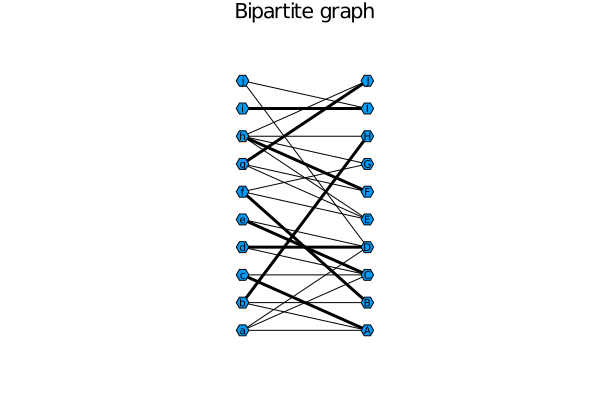

Blossom |M|: 8


In [162]:
P_str = "abcdefghij"; # Specify P here as a string
Q_str = uppercase(P_str); # Specify Q here as a string

P, Q = to_sym(collect(P_str)), to_sym(collect(Q_str)); # creates arrays for P and Q

L = Dict();
L[:a] = [:A, :C, :D];
L[:b] = [:A, :B, :H];
L[:c] = [:A, :C];
L[:d] = [:C, :D];
L[:e] = [:C, :D];
L[:f] = [:B, :E, :G];
L[:g] = [:E, :F, :J];
L[:h] = [:E, :F, :G, :H, :J];
L[:i] = [:I];
L[:j] = [:D, :I];

Msize, M = max_matching_bipartite(P, Q, L; verbose=false, show_graphs=false, nodesize=0.25);

println("Expected |M|: $(Msize)");

mg, names = build_bipartite(P, Q, L);

Mmax = max_matching_blossom(mg; verbose=false, show_graphs=false, nodesize=0.2);

println("Blossom |M|: $(length(Mmax))");

show_plot(plot_fixed(mg; ew=emphasize(Mmax), names=names, curvature=0, nodesize=0.2); title="Bipartite graph");

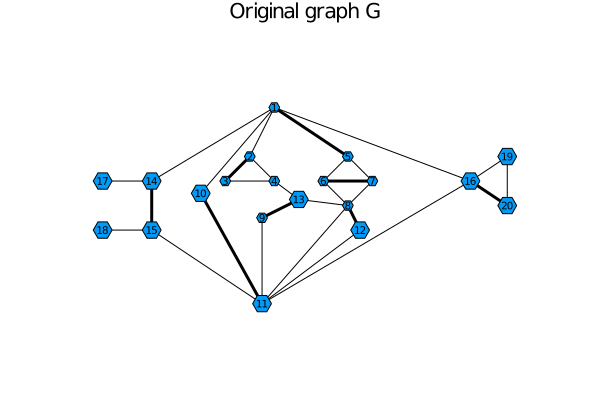

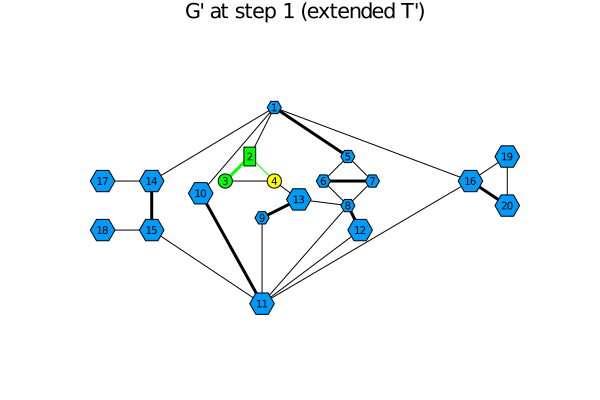

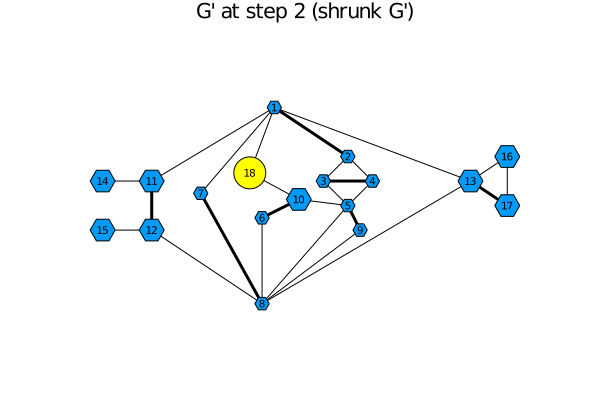

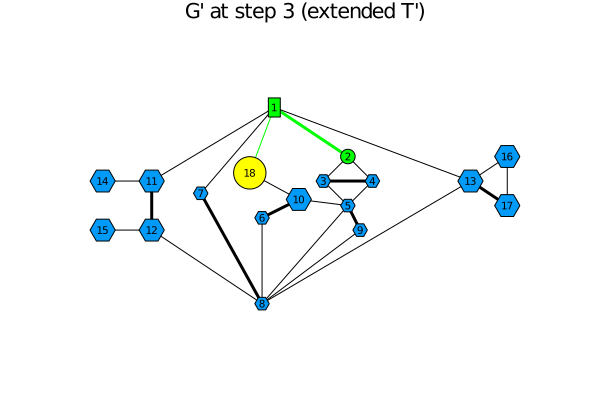

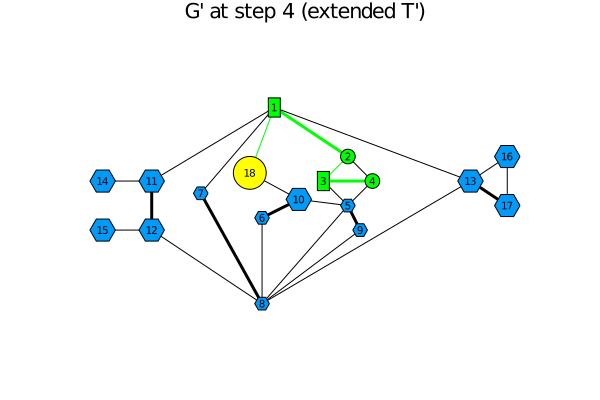

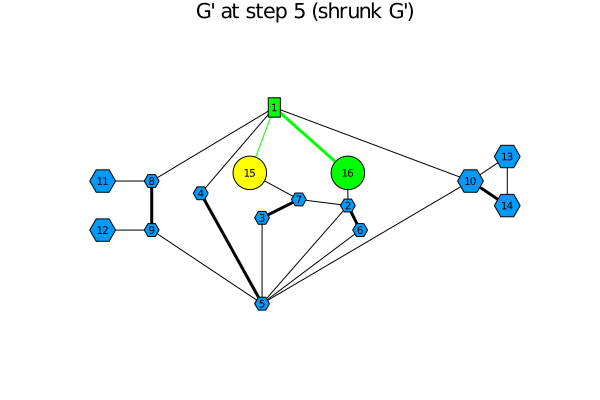

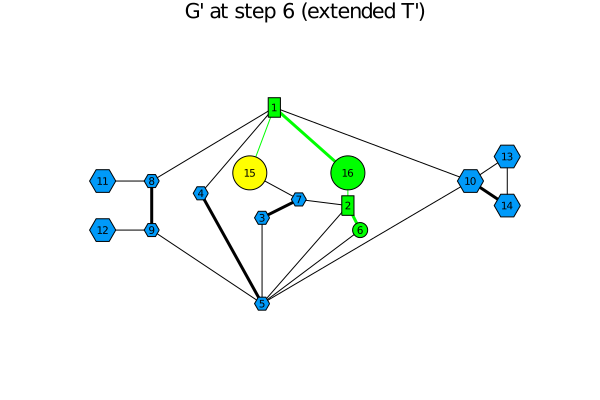

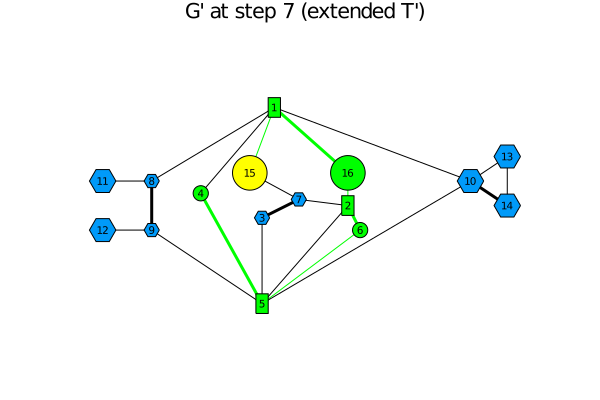

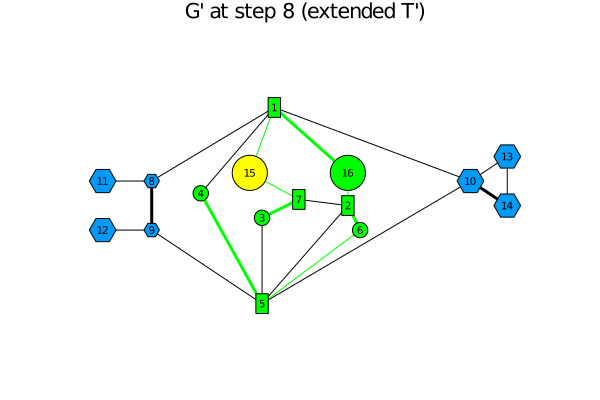

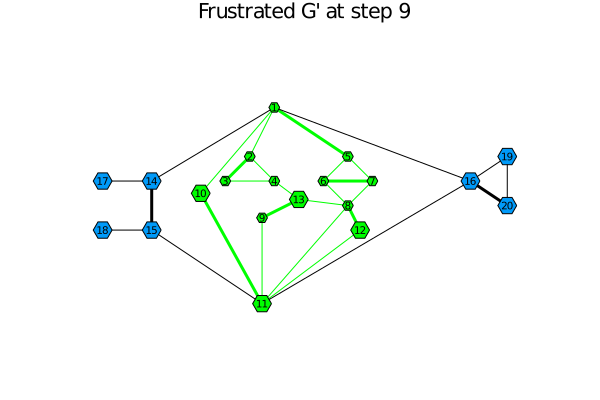

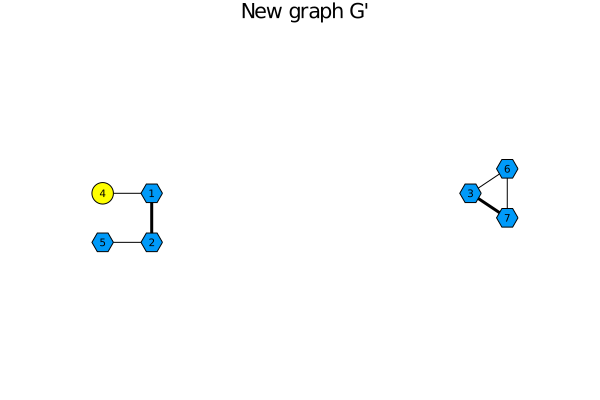

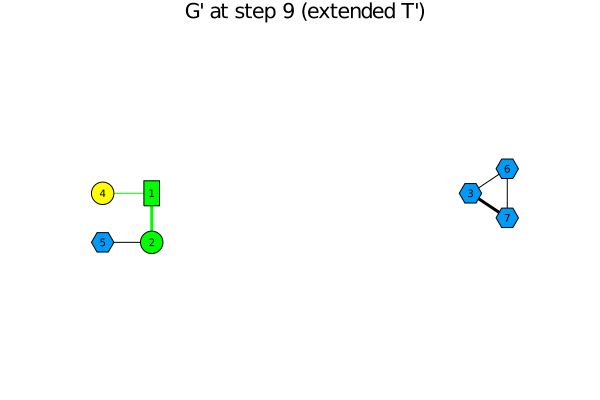

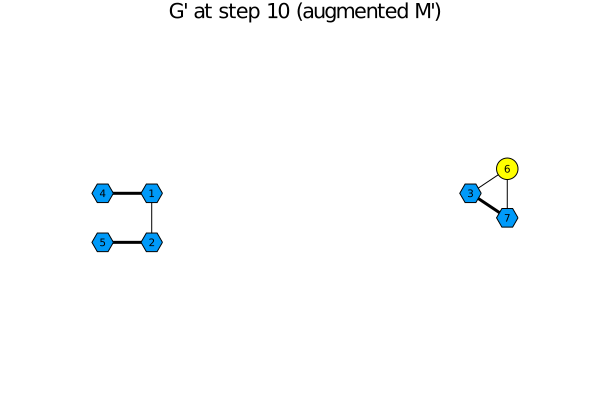

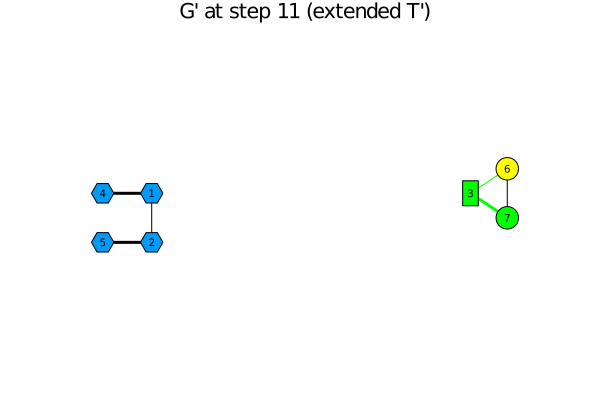

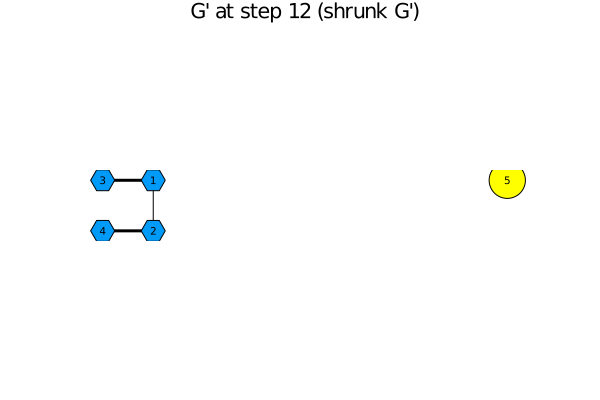

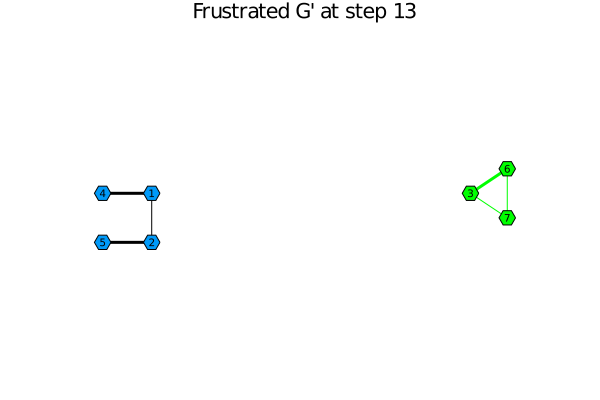

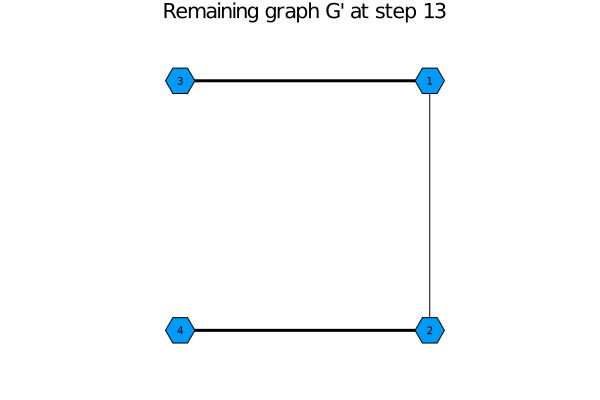

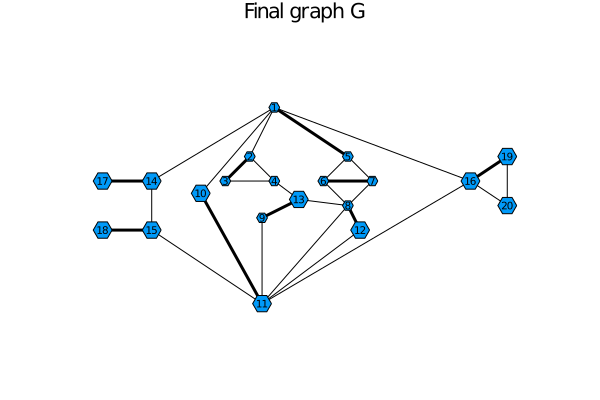

In [125]:
# Example graph from slide 47 of Optimal Matchings
E = Set{Edge{Int}}();

push!(E, Edge(1, 2));
push!(E, Edge(1, 10));
push!(E, Edge(1, 5));
push!(E, Edge(2, 3));
push!(E, Edge(2, 4));
push!(E, Edge(3, 4));
push!(E, Edge(4, 13));
push!(E, Edge(5, 6));
push!(E, Edge(6, 7));
push!(E, Edge(6, 8));
push!(E, Edge(7, 8));
push!(E, Edge(13, 8));
push!(E, Edge(13, 9));
push!(E, Edge(10, 11));
push!(E, Edge(9, 11));
push!(E, Edge(8, 12));
push!(E, Edge(8, 11));
push!(E, Edge(11, 12));
push!(E, Edge(1, 14));
push!(E, Edge(14, 15));
push!(E, Edge(11, 15));
push!(E, Edge(1, 16));
push!(E, Edge(16, 11));
push!(E, Edge(5, 7));
push!(E, Edge(14, 17));
push!(E, Edge(15, 18));
push!(E, Edge(16, 19));
push!(E, Edge(16, 20));
push!(E, Edge(19, 20));

mg = MetaGraph(SimpleGraphFromIterator(E));

place!(mg, 1, (0, 0));
place!(mg, 2, (-1, -2));
place!(mg, 3, (-2, -3));
place!(mg, 4, (0, -3));
place!(mg, 5, (3, -2));
place!(mg, 6, (2, -3));
place!(mg, 7, (4, -3));
place!(mg, 8, (3, -4));
place!(mg, 9, (-0.5, -4.5));
place!(mg, 10, (-3, -3.5));
place!(mg, 11, (-0.5, -8));
place!(mg, 12, (3.5, -5));
place!(mg, 13, (1, -3.75));
place!(mg, 14, (-5, -3));
place!(mg, 15, (-5, -5));
place!(mg, 16, (8, -3));
place!(mg, 17, (-7, -3));
place!(mg, 18, (-7, -5));
place!(mg, 19, (9.5, -2));
place!(mg, 20, (9.5, -4));

M = Set{UEdge{Int}}([UEdge(14, 15), UEdge(10, 11), UEdge(1, 5),
        UEdge(2, 3), UEdge(9, 13), UEdge(6, 7), UEdge(8, 12), UEdge(16, 20)]);

Mmax = max_matching_blossom(mg, M; verbose=false, show_graphs=true);


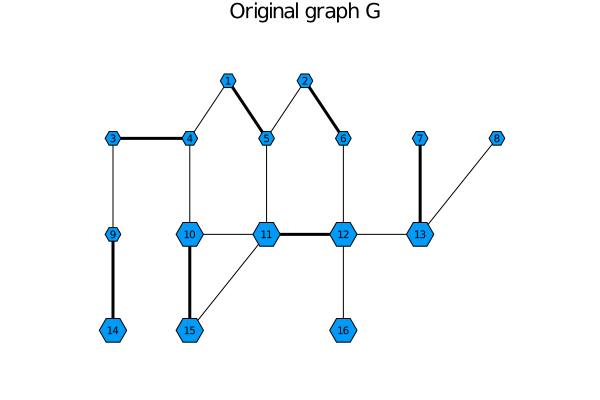

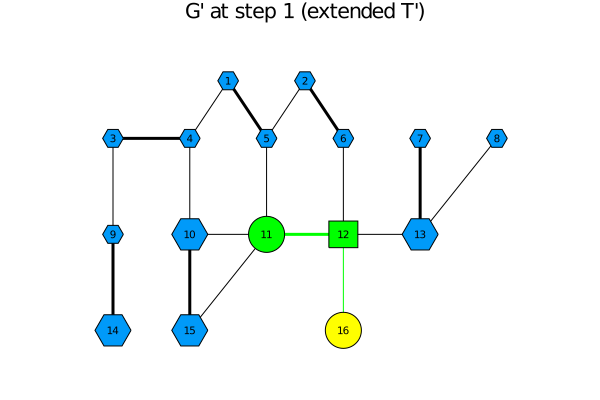

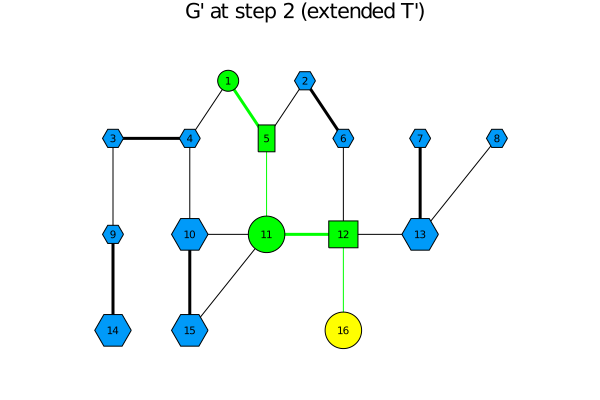

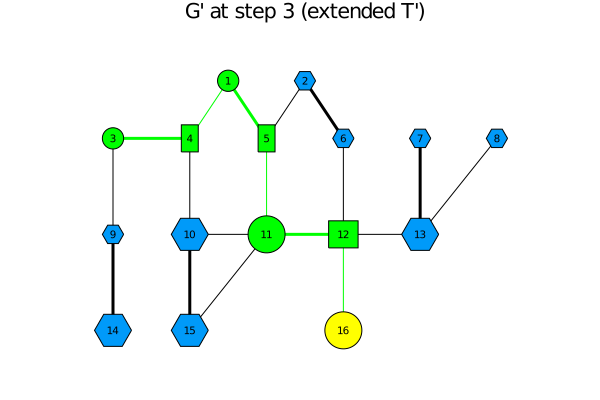

M initialized to {3-4, 7-13, 9-14, 2-6, 11-12, 10-15, 1-5}
=== Loop START ===
--- Step 1 ---
v: 16, w: 12
Extended T: {root: 16; A: {12}; B: {16, 11}; E(T): {12-16, 11-12}}
--- Step 2 ---
v: 11, w: 5
Extended T: {root: 16; A: {5, 12}; B: {16, 11, 1}; E(T): {12-16, 5-11, 11-12, 1-5}}
--- Step 3 ---
v: 1, w: 4
Extended T: {root: 16; A: {4, 5, 12}; B: {3, 16, 11, 1}; E(T): {12-16, 1-4, 3-4, 5-11, 11-12, 1-5}}


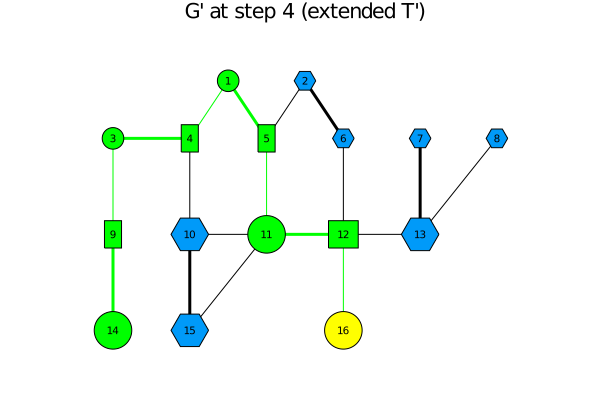

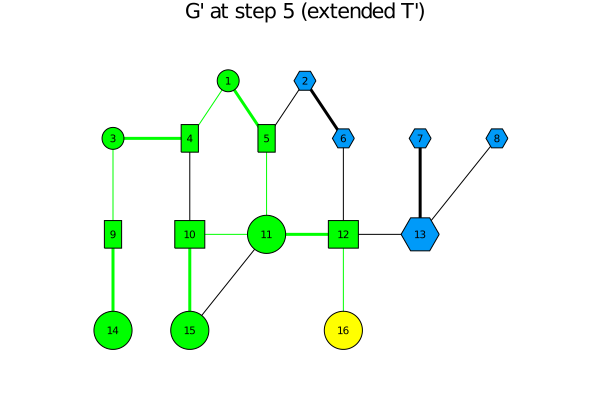

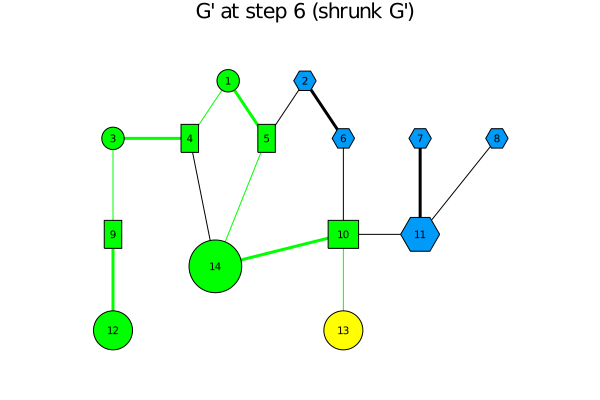

--- Step 4 ---
v: 3, w: 9
Extended T: {root: 16; A: {4, 9, 5, 12}; B: {14, 3, 16, 11, 1}; E(T): {3-9, 12-16, 1-4, 3-4, 5-11, 9-14, 11-12, 1-5}}
--- Step 5 ---
v: 11, w: 10
Extended T: {root: 16; A: {4, 9, 10, 5, 12}; B: {14, 3, 16, 11, 15, 1}; E(T): {3-9, 12-16, 1-4, 3-4, 5-11, 9-14, 10-11, 11-12, 10-15, 1-5}}
--- Step 6 ---
v: 11, w: 15
Shrunk to G'[ V: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
E: {1-4, 1-5, 2-5, 2-6, 3-4, 3-9, 4-14, 5-14, 6-10, 7-11, 8-11, 9-12, 10-11, 10-13, 10-14}
M: {7-11, 9-12, 3-4, 14-10, 2-6, 1-5}
T: {root: 13; A: {4, 9, 10, 5}; B: {13, 14, 3, 12, 1}; E(T): {3-9, 9-12, 5-14, 1-4, 3-4, 10-13, 10-14, 1-5}}
Blossom: {10,11,15} => 14
D2O:
	2 => {2}
	11 => {13}
	7 => {7}
	9 => {9}
	10 => {12}
	8 => {8}
	6 => {6}
	4 => {4}
	3 => {3}
	5 => {5}
	13 => {16}
	14 => {10, 11, 15}
	12 => {14}
	1 => {1}
S:
	2 => {2}
	11 => {13}
	7 => {7}
	9 => {9}
	10 => {12}
	8 => {8}
	6 => {6}
	4 => {4}
	3 => {3}
	5 => {5}
	13 => {16}
	14 => {10, 11, 15}
	12 => {14}
	1 => {1} ]


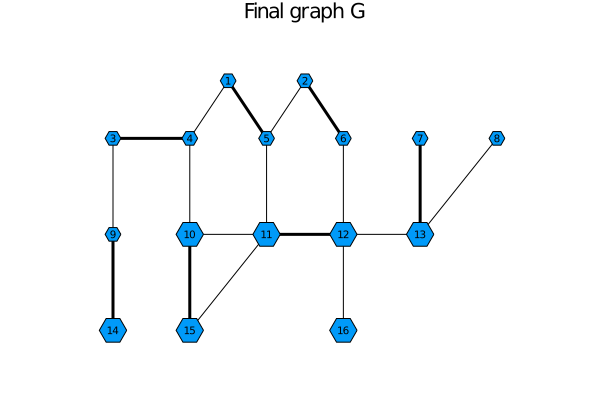

--- Step 7 ---
=== Loop END ===
Final M: {3-4, 7-13, 9-14, 2-6, 11-12, 10-15, 1-5}
No perfect matching exists! (A frustrated tree was found...)


In [124]:
# Example graph from Assignment 6, exercise 2
E = Set{Edge{Int}}();

push!(E, Edge(1, 4));
push!(E, Edge(1, 5));
push!(E, Edge(2, 5));
push!(E, Edge(2, 6));
push!(E, Edge(3, 4));
push!(E, Edge(3, 9));
push!(E, Edge(4, 10));
push!(E, Edge(5, 11));
push!(E, Edge(6, 12));
push!(E, Edge(7, 13));
push!(E, Edge(8, 13));
push!(E, Edge(9, 14));
push!(E, Edge(10, 15));
push!(E, Edge(10, 11));
push!(E, Edge(11, 12));
push!(E, Edge(11, 15));
push!(E, Edge(12, 16));
push!(E, Edge(12, 13));

mg = MetaGraph(SimpleGraphFromIterator(E));

place!(mg, 3, (0, 0));
place!(mg, 4, (1, 0));
place!(mg, 1, (1.5, 0.75));
place!(mg, 5, (2, 0));
place!(mg, 2, (2.5, 0.75));
place!(mg, 6, (3, 0));
place!(mg, 7, (4, 0));
place!(mg, 8, (5, 0));
place!(mg, 9, (0, -1.25));
place!(mg, 10, (1, -1.25));
place!(mg, 11, (2, -1.25));
place!(mg, 12, (3, -1.25));
place!(mg, 13, (4, -1.25));
place!(mg, 14, (0, -2.5));
place!(mg, 15, (1, -2.5));
place!(mg, 16, (3, -2.5));

M = Set([UEdge(1, 5), UEdge(2, 6), UEdge(3, 4), UEdge(7, 13), UEdge(9, 14), UEdge(10, 15), UEdge(11, 12)])

# plot_fixed(mg; ew=emphasize(M), curvature=0)

perfect, Mfinal = perfect_matching_blossom(mg, M; verbose=true, show_graphs=true);
# Mmax = max_matching_blossom(mg, M; verbose=true, show_graphs=true);

## TSP
- [Christofide's Algorithm](#Christofide's-Algorithm)
- [Christofide's Input](#Christofide's-Input)

### Christofide's Algorithm

In [ ]:
function Christofides(mg::MetaGraph;
        show_graphs::Bool=false, verbose::Bool=false, 
        names::Vector{S}=Vector(1:nv(mg)), args...) where {S <: Union{String, Symbol, Int}}
    
    ename(e::T) where {T <: AbstractEdge} = "$(names[e.src]) <=> $(names[e.dst])";
    log(msg::Any) = verbose ? println(msg) : nothing # printer
    
    # Dictionary of weights
    wd = Dict((e.src, e.dst) => get_prop(mg, e, :weight) for e in edges(mg));
    for e in edges(mg)
        re = reverse(e);
        wd[re.src, re.dst] = wd[e.src, e.dst]; # add reverse edges too
    end
    
    show_plot(plot_fixed(mg; names=names, el=wd, curvature=0.01, args...); show=show_graphs, title="Input graph G");
    
    mst_edges = kruskal_mst(mg); # get MST
    T, Tmap = induced_subgraph(mg, mst_edges);
    log("c(T): " * sum_str(wts(mst_edges, wd)));
    show_plot(plot_fixed(mg; el=Dict((e.src, e.dst)=>wd[e.src, e.dst] for e in mst_edges), 
        ew=emphasize(mst_edges; in_weight=3, out_weight=0.2), curvature=0, names=names, args...);
        show=show_graphs, title="MST T");
    
    W = S[];
    for v in vertices(T)
        deg = degree(T, v);
        log("deg($(names[Tmap[v]])) = $(deg)")
        if deg % 2 == 1
            push!(W, Tmap[v])
        end
    end
    log("W (odd-degree nodes in T): " * join(W, ", "))
    
    sg, Wmap = induced_subgraph(mg, W);
    match = minimum_weight_perfect_matching(SimpleGraph(sg), 
        Dict(e => wd[Wmap[e.src], Wmap[e.dst]] for e in edges(sg)));
    el = Dict([(e.src, e.dst)=>wd[Wmap[e.src], Wmap[e.dst]] for e in edges(sg)]...);
    for e in edges(sg)
        el[e.dst, e.src] = wd[Wmap[e.src], Wmap[e.dst]]; # add reverse edges
    end
    inv_Wmap = Dict(v => i for (i, v) in enumerate(Wmap)); # Inverse W map
    M = unique([Edge(Wmap[v], Wmap[match.mate[v]]) for v in vertices(sg)]);
    log("Matching M:\n" * join(["$(names[e.src]) <=> $(names[e.dst])" for e in M], "\n"))
    log("c(M): " * sum_str(wts(M, wd)))
    show_plot(plot_fixed(sg; ew=emphasize(map((e)->Edge(inv_Wmap[e.src], inv_Wmap[e.dst]), M); out_weight=0.2),
            el=el, pos=[get_prop(mg, Wmap[v], :position) for v in vertices(sg)],
            curvature=0, names=Wmap, args...); show=show_graphs, title="Min-cost Matching M of G[W]");
    
    C = unique([mst_edges..., M...]); # Euler circuit with M + mst
    cg, Cmap = induced_subgraph(mg, C);
    show_plot(plot_fixed(mg; ew=emphasize(C; out_weight=0.2), el=wd, curvature=0,
            names=names, args...); show=show_graphs, title="T + M")
    
    log("Combined T + M:")
    log(join(["$(ename(e))" for e in C], "\n"))
    return C;
end;

### Christofide's Input

In [ ]:
mg = MetaGraph(SimpleGraph(8));

wd = Dict{Tuple{Int, Int}, Float64}();

positions = Dict();
positions[1] = (0,0); positions[2] = (2,0); positions[3] = (4,0);
positions[4] = (1,-2); positions[5] = (3,-2);
positions[6] = (-0.5,-3); positions[7] = (1,-3.5); positions[8] = (4,-3);
for (v, pos) in positions
    x, y = pos;
    place!(mg, v, (x, y));
end

connect!(mg, 1, 2, 11; wd=wd);
connect!(mg, 2, 3, 11; wd=wd);
connect!(mg, 1, 4, 4; wd=wd);
connect!(mg, 1, 6, 7; wd=wd);
connect!(mg, 2, 4, 7; wd=wd);
connect!(mg, 2, 5, 6; wd=wd);
connect!(mg, 3, 5, 5; wd=wd);
connect!(mg, 3, 8, 6; wd=wd);
connect!(mg, 4, 5, 1; wd=wd);
connect!(mg, 4, 6, 3; wd=wd);
connect!(mg, 4, 7, 9; wd=wd);
connect!(mg, 5, 8, 2; wd=wd);
connect!(mg, 6, 7, 7; wd=wd);
connect!(mg, 7, 8, 11; wd=wd);

In [ ]:
C = Christofides(mg; show_graphs=true, verbose=true, elb=false, elo=0.015, curvature=0);

In [ ]:
tour = C[:];
remove!(Edge(4, 6), tour);
push!(tour, Edge(6, 1));

remove!(Edge(2, 5), tour);
remove!(Edge(4, 5), tour);
push!(tour, Edge(4, 2));

In [ ]:
# tour = C[:];
# remove!(Edge(4, 6), tour);
# push!(tour, Edge(6, 1));

# remove!(Edge(2, 5), tour);
# remove!(Edge(4, 5), tour);
# push!(tour, Edge(4, 2));

println("Tour: ")
nodes = tour[:];
path = [1];
while !isempty(nodes)
    curr = last(path);
    next = remove!(Edge(1, 2), nodes; condition=(e)->incident(curr, e));
    if isempty(next)
        push!(path, 1)
        break;
    end
    edge = next[1];
    curr = (edge.src == curr ? edge.dst : edge.src)
    push!(path, curr)
end
push!(path, 1)
println(join(path, " <-> "))

tour = connect(path);

println("Cost of Christofide's Tour: " * sum_str(wts(tour, wd)))

plot_fixed(mg; ew=emphasize(tour; out_weight=0.2), el=wd, curvature=0, elb=false, elo=0.025)